# Setup

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy
import warnings
import csv
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
%load_ext autoreload
%aimport networks
from networks import BAGraph
%aimport log_bin
# helper functions
%aimport utils
font_size = 20
%autoreload 1

# Fixed N and varying m

In [3]:
from collections import Counter

folder = "data/ba/deg_dist"
N = 10**6
M = [1, 2, 4, 8, 16, 32]
fixed_n_df = pd.DataFrame()
for m in M:
    print(m)
    data = []
    # number of repeats
    for i in range(1,41):
        folder_name = folder + str(i) + "/"
        filename = "{0}_{1}.txt".format(N, m)
        filepath = folder_name + filename
        with open(filepath, 'r') as f:
            reader = csv.reader(f)
            data_as_list = list(reader)
        x = data_as_list[0]
        x = [int(i) for i in x]
        data.append(x)
    counters = [Counter(x) for x in data]
    sums = dict(sum(counters, Counter()))
    data_mean = {x: float(sums[x]) / len(data) for x in sums.keys()}
    additional = pd.DataFrame.from_dict(data_mean, orient="index")
    additional.columns = [m]
    fixed_n_df = pd.concat([fixed_n_df, additional], axis=1)

1
2
4
8
16
32


In [8]:
fixed_n_degrees = fixed_n_df

for col in fixed_n_degrees:
    total = fixed_n_degrees[col].dropna().sum()
    fixed_n_degrees[col] = fixed_n_degrees[col] / total

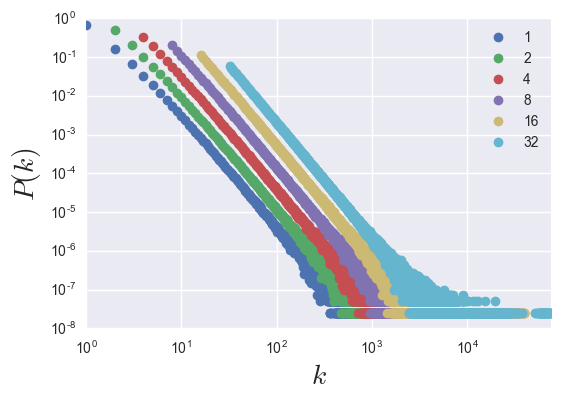

In [10]:
fixed_n_degrees.plot(style='o', loglog=True)
ax = plt.gca()
ax.set_ylabel(u'$P(k)$', fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)

## Visualizing ccdf

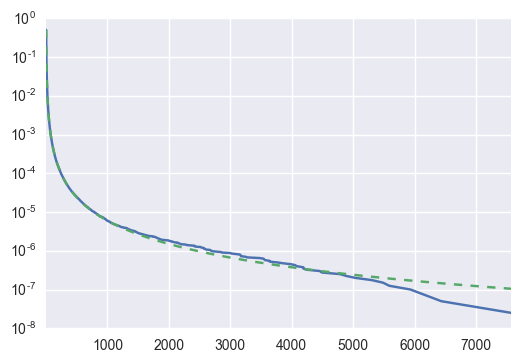

In [33]:
utils.visualize_ccdf(fixed_n_degrees, 2)

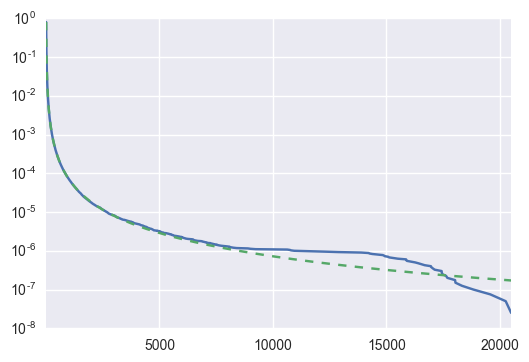

In [30]:
utils.visualize_ccdf(fixed_n_degrees, 8)

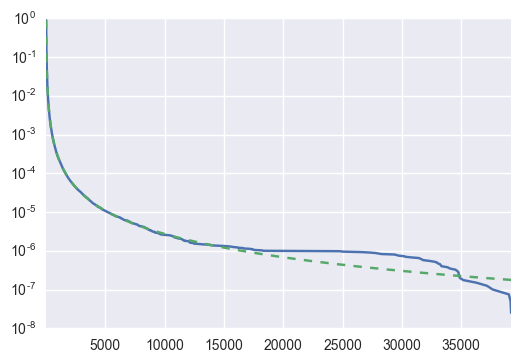

In [31]:
utils.visualize_ccdf(fixed_n_degrees, 16)

## log bin

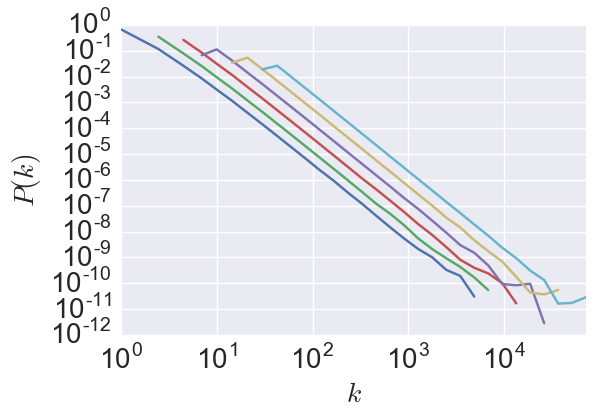

In [12]:
fixed_n_logbin = utils.log_bin_freq_and_plot(fixed_n_degrees, a=1.4, font_size=font_size, style='-', loglog=True)

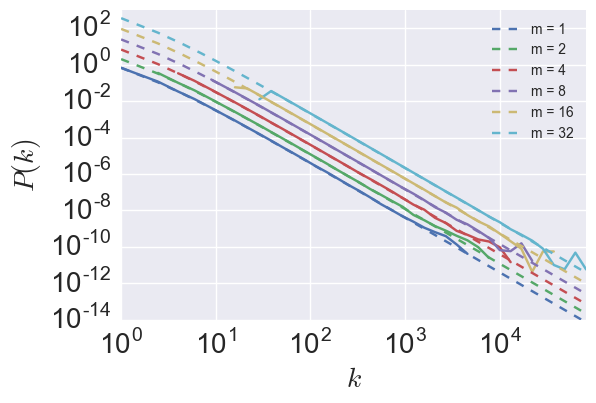

In [85]:
# plot numerical results
utils.log_bin_freq_and_plot(fixed_n_degrees, a=1.3, font_size=font_size, style='-', loglog=True, label='__nolegend__')
result = utils.get_model_df(fixed_n_logbin, fixed_n_logbin.columns)

# plot model
current_palette = sns.color_palette()
for i, col in enumerate(result):
    result[col].dropna().plot(loglog=True, style='--', color=current_palette[i], label='m = '+str(col))
plt.legend()

## ks test

1     1.000000
2     0.999990
4     0.991878
8     0.916805
16    0.514130
32    0.216382
dtype: float64

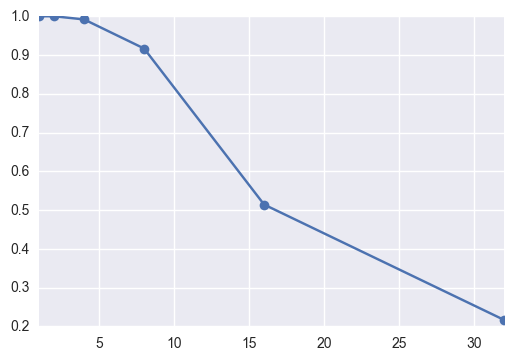

In [28]:
pvalues = []
for col in fixed_n_logbin:
    model_values = utils.deg_dist_theory(col, fixed_n_logbin[col].dropna().index)
    ks_stat, pvalue = scipy.stats.ks_2samp(fixed_n_logbin[col].dropna().values, model_values)
    pvalues.append(pvalue)
display(pd.Series(pvalues, index=fixed_n_logbin.columns))
pd.Series(pvalues, index=fixed_n_logbin.columns).plot(style='-o')

For small m, p-value from the KS test is very close to 1.

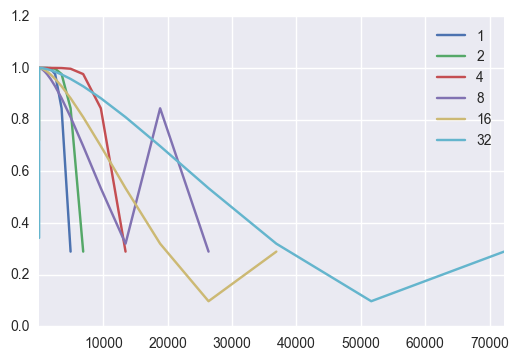

In [74]:
ks_pvalues = pd.DataFrame()
for col in fixed_n_logbin:
    model_values = utils.deg_dist_theory(col, fixed_n_logbin[col].dropna().index)
    col_list = []
    for i, value in enumerate(fixed_n_logbin[col]):
        if value == np.nan or i == 0:
            col_list.append(np.nan)
            continue
        if fixed_n_logbin[col].tail(-i).dropna().empty:
            col_list.append(np.nan)
            continue
        ks_stat, pvalue = scipy.stats.ks_2samp(fixed_n_logbin[col].tail(-i).dropna().values, model_values[i:])
        
        col_list.append(pvalue)
    additional = pd.DataFrame({col: col_list}, index=fixed_n_logbin[col].index)
    ks_pvalues = pd.concat([ks_pvalues, additional], axis=1)
ks_pvalues.plot(style='-')

## r2

1     0.999767
2     0.010811
4     0.000798
8     0.005077
16    0.006037
32    0.005480
dtype: float64

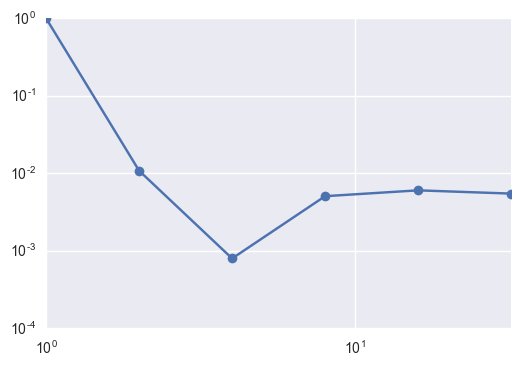

In [104]:
r2s = []
for col in fixed_n_logbin:
    model_values = utils.deg_dist_theory(col, fixed_n_logbin[col].dropna().index)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fixed_n_logbin[col].dropna().values, model_values)
    r2s.append(r_value**2)
display(pd.Series(r2s, index=fixed_n_logbin.columns))
pd.Series(r2s, index=fixed_n_logbin.columns).plot(style='-o', loglog=True)

## Pearson coefficient

In [16]:
model_df = utils.get_model_df(fixed_n_logbin, fixed_n_logbin.columns)
# model_df.corrwith(fixed_n_logbin)
from IPython.display import display
for col in fixed_n_logbin:
    new_df = pd.DataFrame({'numerical': fixed_n_logbin[col], 'theory': model_df[col]}, index=fixed_n_logbin.index)
    new_df = new_df.dropna()
    print(col)
    display(new_df.corr())

1


,numerical,theory
numerical,1.000000,0.999884
theory,0.999884,1.000000


2


,numerical,theory
numerical,1.000000,0.103975
theory,0.103975,1.000000


4


,numerical,theory
numerical,1.000000,-0.028242
theory,-0.028242,1.000000


8


,numerical,theory
numerical,1.00000,-0.07125
theory,-0.07125,1.00000


16


,numerical,theory
numerical,1.000000,-0.077697
theory,-0.077697,1.000000


32


,numerical,theory
numerical,1.000000,-0.074029
theory,-0.074029,1.000000


# Fixed m and varying N

In [86]:
from collections import Counter

folder = "data/ba/deg_dist"
powers_of_n = np.arange(2, 7)
N = 10**powers_of_n
m = 1
df = pd.DataFrame()
for n in N:
    print(n)
    # number of repeats
    data = []
    for i in range(1,41):
        folder_name = folder + str(i) + "/"
        filename = "{0}_{1}.txt".format(n, m)
        filepath = folder_name + filename
        with open(filepath, 'r') as f:
            reader = csv.reader(f)
            data_as_list = list(reader)
        x = data_as_list[0]
        x = [int(i) for i in x]
        data.append(x)
    counters = [Counter(x) for x in data]
    sums = dict(sum(counters, Counter()))
    data_mean = {x: float(sums[x]) / len(data) for x in sums.keys()}
    additional = pd.DataFrame.from_dict(data_mean, orient="index")
    additional.columns = [n]
    df = pd.concat([df, additional], axis=1)

100
1000
10000
100000
1000000


In [87]:
degrees_df = df

for col in degrees_df:
    total = degrees_df[col].dropna().sum()
    degrees_df[col] = degrees_df[col] / total

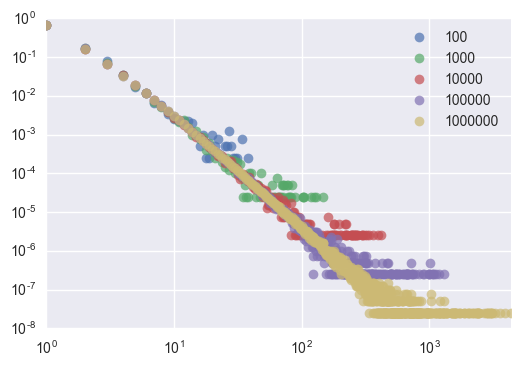

In [88]:
degrees_df.plot(loglog=True, style='o', alpha=0.7)

## log bin

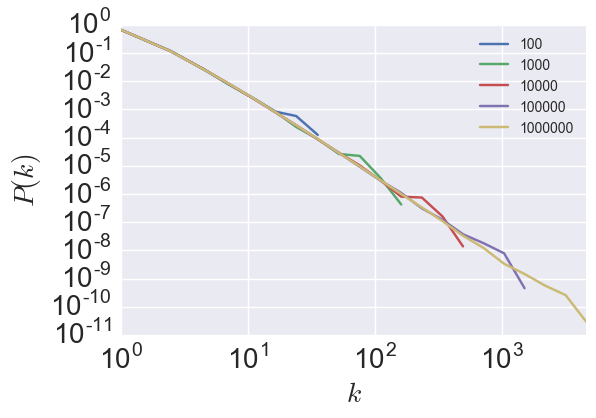

In [95]:
a = list(np.linspace(1.2, 1.5, len(degrees_df.columns)))
log_binned_df = utils.log_bin_freq_and_plot(degrees_df, a=1.45, font_size=font_size, style='-', loglog=True)
plt.legend()

There is a dip then a bump, and they seem equally spaced on a loglog plot, implying a power law governing finite size scaling effects. 

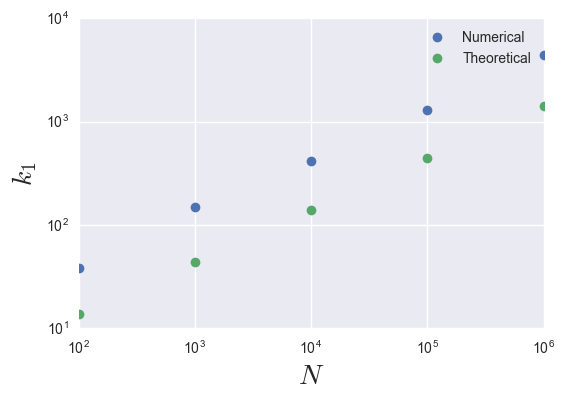

In [96]:
largest_expected_degree = []
largest_degree_theory = []
for col in degrees_df:
    a = degrees_df[col].dropna()[degrees_df[col] != 0].tail(1).index.values[0]
    k1 = utils.largest_degree(col, m)
    largest_expected_degree.append(a)
    largest_degree_theory.append(k1)
current_palette = sns.color_palette()
numerical = pd.Series(largest_expected_degree, index=degrees_df.columns)
numerical.plot(style='o', loglog=True, label='Numerical')
theoretical = pd.Series(largest_degree_theory, index=degrees_df.columns)
theoretical.plot(marker='o', linestyle='None', color=current_palette[1],
                                                                loglog=True, label='Theoretical')
ax = plt.gca()
plt.legend()
ax.set_ylabel(u"$k_1$", fontsize=font_size)
ax.set_xlabel(u"$N$", fontsize=font_size)

Numerical result is offset from the theoretical result by a constant value. We can then look at deviations from theoretical distribution for these systems. 

In [98]:
deviations = numerical / theoretical
deviations

100        2.783685
1000       3.346587
10000      2.973271
100000     2.898947
1000000    3.097516
dtype: float64

## Data collapse

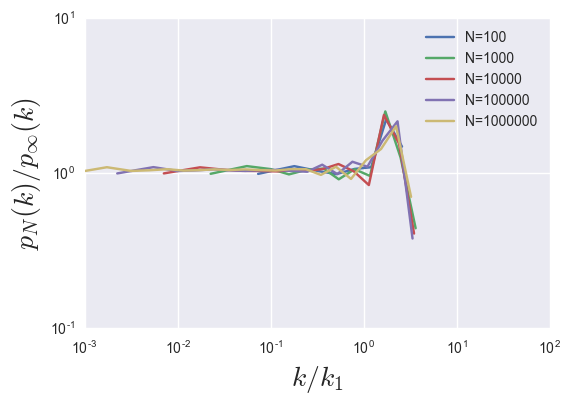

In [99]:
# using theoretical k1
data_collapse = log_binned_df
ax = plt.figure().gca()
for col in data_collapse:
    temp = pd.DataFrame()
    temp['y'] = data_collapse[col].dropna() / utils.deg_dist_theory(m, data_collapse[col].dropna().index.values)
    temp['x'] = data_collapse[col].dropna().index.values / utils.largest_degree(col, m)
    temp[temp != 0].plot(x='x', y='y', loglog=True, ax=ax, label="N=" + str(col), xlim=(1e-3, 1e2))

ax.set_ylabel(u'$p_N(k) / p_{\infty}(k)$', fontsize=font_size)
ax.set_xlabel(u'$k/k_1$', fontsize=font_size)

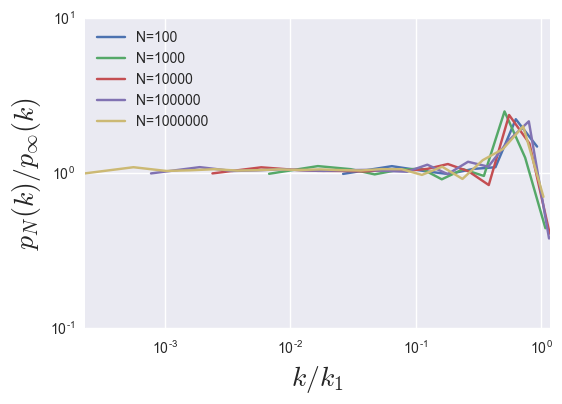

In [100]:
# using observed k1
data_collapse = log_binned_df
ax = plt.figure().gca()
for col in data_collapse:
    temp = pd.DataFrame()
    temp['y'] = data_collapse[col].dropna() / utils.deg_dist_theory(m, data_collapse[col].dropna().index.values)
    k1 = degrees_df[col].dropna()[degrees_df[col] != 0].tail(1).index.values[0]
    temp['x'] = data_collapse[col].dropna().index.values / k1
    temp[temp != 0].plot(x='x', y='y', loglog=True, ax=ax, label="N=" + str(col))

ax.set_ylabel(u'$p_N(k) / p_{\infty}(k)$', fontsize=font_size)
ax.set_xlabel(u'$k/k_1$', fontsize=font_size)